In [1]:
import numpy as np
import torch
import time
from Detectors.Deep_Learning.AutoEncoders.utils import SeqDataset,train_epoch,eval_data,train_model,get_cnn_lstm_ae_model,make_train_X,sliding_window_mult_feat
from Detectors.Deep_Learning.AutoEncoders.utils import get_loss_filter_indiv as loss_smooth
from Detectors.Deep_Learning.AutoEncoders.cnn_lstm_ae import CNNRecurrentAutoencoder


import flow.visualize.visualize_ring as visualize_ring
from flow.visualize.visualize_ring import get_measured_leader,get_rel_dist_to_measured_leader,get_vel_of_measured_leader

from copy import deepcopy
import sys
import utils
from utils import assess_relative_model_on_attack
import ray
import os
import csv
from sklearn.metrics import roc_curve,auc

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import flow
reload(flow)

import Detectors.Deep_Learning.AutoEncoders.utils
reload(Detectors.Deep_Learning.AutoEncoders.utils)
from Detectors.Deep_Learning.AutoEncoders.utils import SeqDataset,train_epoch,eval_data,train_model

import torch

# Anti-Flow specific functions for  detection:

from Detectors.Deep_Learning.AutoEncoders.utils import sliding_window
from Detectors.Deep_Learning.AutoEncoders.cnn_lstm_ae import CNNRecurrentAutoencoder

import utils
reload(utils)

from utils import Bando_OVM_FTL

import os
import shutil

from Adversaries.controllers import car_following_adversarial

reload(car_following_adversarial)

import Adversaries.controllers.car_following_adversarial
from Adversaries.controllers.car_following_adversarial import FollowerStopper_Overreact
from Adversaries.controllers.car_following_adversarial import ACC_Benign
from Adversaries.controllers.car_following_adversarial import ACC_Switched_Controller_Attacked

from flow.controllers.lane_change_controllers import AILaneChangeController

from utils import run_ring_sim_variable_cfm

from Adversaries.controllers import car_following_adversarial

reload(car_following_adversarial)

import time

from utils import run_ring_sim_variable_cfm

print('Libraries loaded.')


Libraries loaded.


In [2]:
import attack_param_sweep_single_lane
reload(attack_param_sweep_single_lane)

<module 'attack_param_sweep_single_lane' from '/Users/vanderbilt/Desktop/Research_2022/Anti-Flow/detector_dev/attack_param_sweep_single_lane.py'>

In [6]:
from attack_param_sweep_single_lane import make_benign_driver_list_single_lane,make_mal_driver_list

driver_controller_list_no_attack = make_benign_driver_list_single_lane()

# emission_path = os.path.join(os.getcwd(),'/data')
emission_path = 'data'

benign_sim_emission_path = run_ring_sim_variable_cfm(driver_controller_list = driver_controller_list_no_attack,
                                                     ring_length=600,
                                                     sim_time=300,
                                                     emission_path=emission_path)

benign_sim_emission_path = benign_sim_emission_path[1]

Number of classes of driver: 40
Running ring simulation, ring length: 600


/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 1660.8977051869147
data/ring_variable_cfm_20220530-1010581653923458.5404868-0_emission.csv data
Average, std velocities: 6.101316707222113, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1660.8977051869147, 0.0
Total time: 27.37390899658203
steps/second: 125.30768049771001


In [10]:
import process_losses_ring_attack
reload(process_losses_ring_attack)

from process_losses_ring_attack import get_losses_complete_obs

model = get_cnn_lstm_ae_model(n_features=4)

# Load in a trained model:
MODEL_PATH = '/Users/vanderbilt/Desktop/Research_2022/Anti-Flow/detector_dev/models/cnn_lstm_ae_ringlength600_1lane__1.0percentGPS.pt'
model.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device('cpu')))


losses_dict_benign = get_losses_complete_obs(benign_sim_emission_path,model)



Data loaded.
Vehicles processed: 40



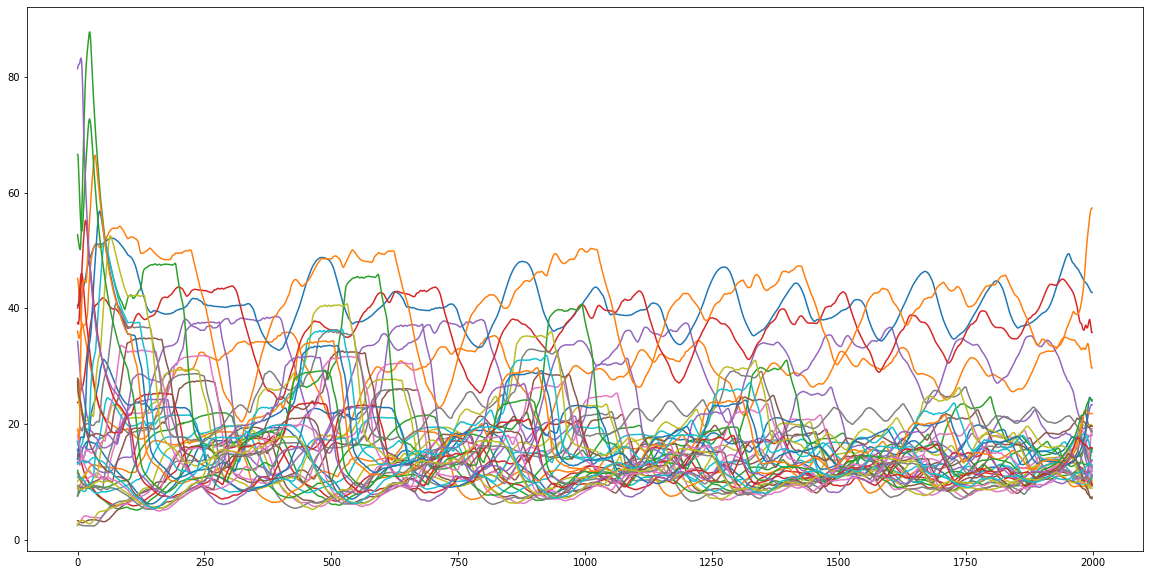

In [28]:
plt.figure(figsize=[20,10])

for veh_id in losses_dict_benign:
    plt.plot(losses_dict_benign[veh_id])

In [29]:
max_loss_all = 0.0

for veh_id in losses_dict_benign:
    max_loss = np.max(losses_dict_benign[veh_id][500:])
    if(max_loss > max_loss_all): max_loss_all = max_loss
        
print(max_loss_all)

57.3343620300293


In [16]:
from utils import k_means_classify,threshold_classification

import process_losses_ring_attack
reload(process_losses_ring_attack)

from process_losses_ring_attack import get_all_loss_results


loss_results_repo = '/Volumes/My Passport for Mac/single_lane_ring_road_attack_parameter_sweep'
loss_results_repo = os.path.join(loss_results_repo,'loss_results_1.0_GPS')

all_max_losses_dict = get_all_loss_results(loss_results_repo)

In [30]:
from process_losses_ring_attack import get_attack_params

attack_keys = list(all_max_losses_dict.keys())

temp_key = attack_keys[-1]

max_losses_temp_benign = all_max_losses_dict[temp_key]['ben']

max_losses_temp_mal = all_max_losses_dict[temp_key]['mal']

labels_ben = threshold_classification(max_losses=max_losses_temp_benign,threshold=max_loss_all)

labels_mal = threshold_classification(max_losses=max_losses_temp_mal,threshold=max_loss_all)

print('Assigned labels.')

Assigned labels.


(array([ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 18.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

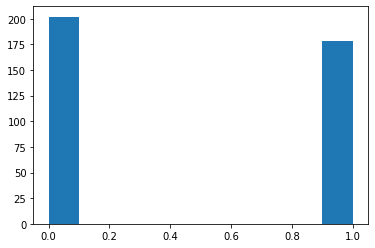

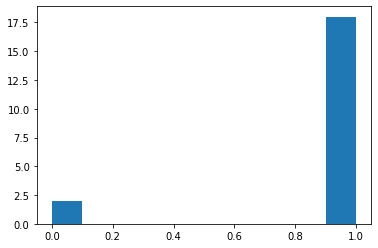

In [31]:
plt.figure()
plt.hist(labels_ben)


plt.figure()
plt.hist(labels_mal)

In [33]:
number_false_positives = np.sum(labels_ben == 1)
number_true_positives = np.sum(labels_mal == 1)

number_false_negatives = np.sum(labels_mal == 0)
number_true_negatives = np.sum(labels_ben == 0)

print(number_false_positives)
print(number_true_positives)
print(number_false_negatives)
print(number_true_negatives)

178
18
2
202


In [90]:

param_vals = []

FP_vals = []
TP_vals = []
TN_vals = []
FN_vals = []



for key in attack_keys:
    
    params = get_attack_params(key)
    param_vals.append(params)
    
    max_losses_temp_benign = all_max_losses_dict[key]['ben']
    max_losses_temp_mal = all_max_losses_dict[key]['mal']
    
    labels_ben = threshold_classification(max_losses=max_losses_temp_benign,threshold=max_loss_all)
    labels_mal = threshold_classification(max_losses=max_losses_temp_mal,threshold=max_loss_all)
    
    number_false_positives = np.sum(np.array(labels_ben) == 1)
    number_true_positives = np.sum(np.array(labels_mal) == 1)

    number_false_negatives = np.sum(np.array(labels_mal) == 0)
    number_true_negatives = np.sum(np.array(labels_ben) == 0)
    
    FP_vals.append(number_false_positives)
    TP_vals.append(number_true_positives)
    FN_vals.append(number_false_negatives)
    TN_vals.append(number_true_negatives)
    
print('Found classification statistics.')

Found classification statistics.


Text(0.5, 0.98, 'Classification results single-lane, threshold')

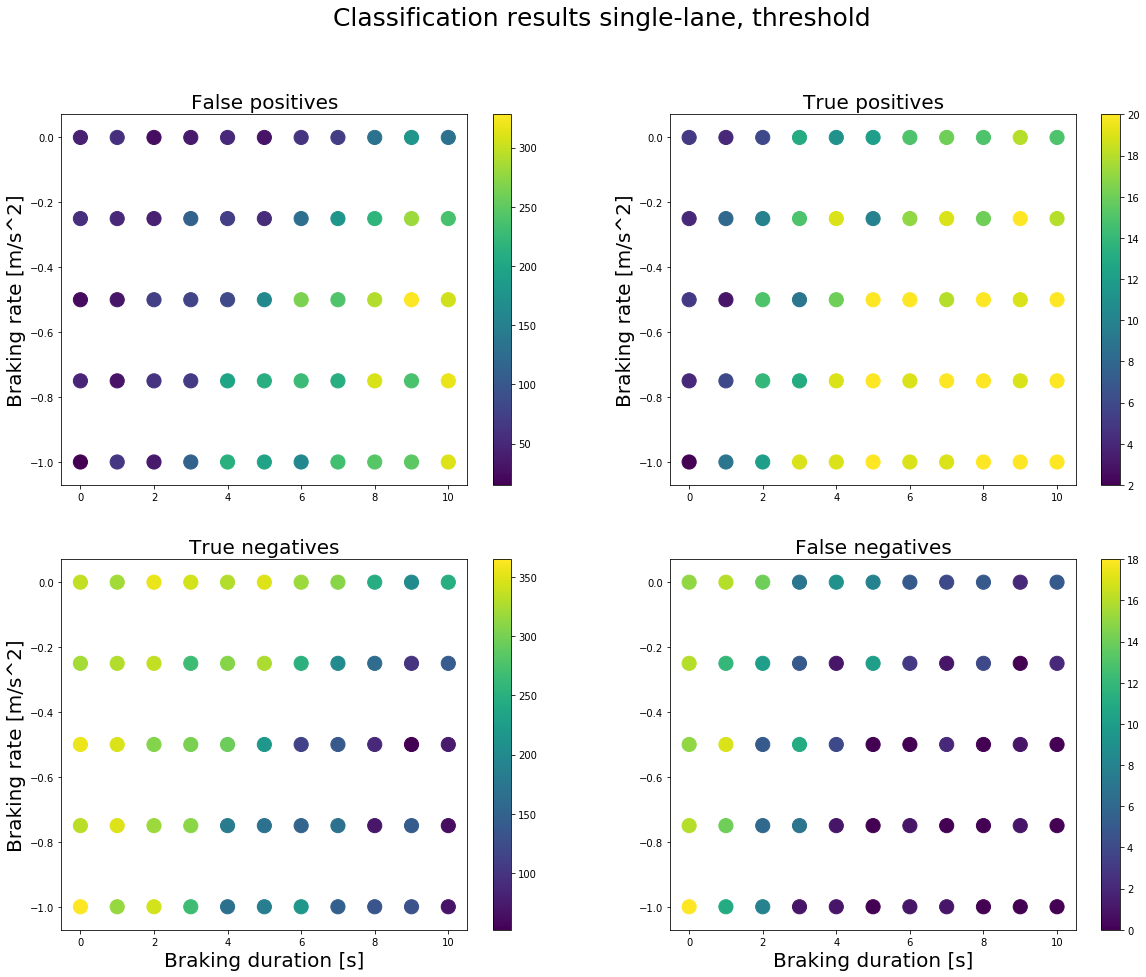

In [91]:
fig = plt.figure(figsize=[20,15])


dot_size = 200


param_vals_np_arr = np.array(param_vals)

TAD = param_vals_np_arr[:,0]
ADR = param_vals_np_arr[:,1]

plt.subplot(2,2,1)
plt.scatter(TAD,ADR,c=FP_vals,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
# plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.title('False positives',fontsize=20)


plt.subplot(2,2,2)
plt.scatter(TAD,ADR,c=TP_vals,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
# plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.title('True positives',fontsize=20)

plt.subplot(2,2,3)
plt.scatter(TAD,ADR,c=TN_vals,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.title('True negatives',fontsize=20)

plt.subplot(2,2,4)
plt.scatter(TAD,ADR,c=FN_vals,s=dot_size)
# plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.title('False negatives',fontsize=20)

fig.suptitle('Classification results single-lane, threshold', fontsize=25)
    
# fig.title('Classification results')

Text(0.5, 0.98, 'Classification results single-lane, threshold')

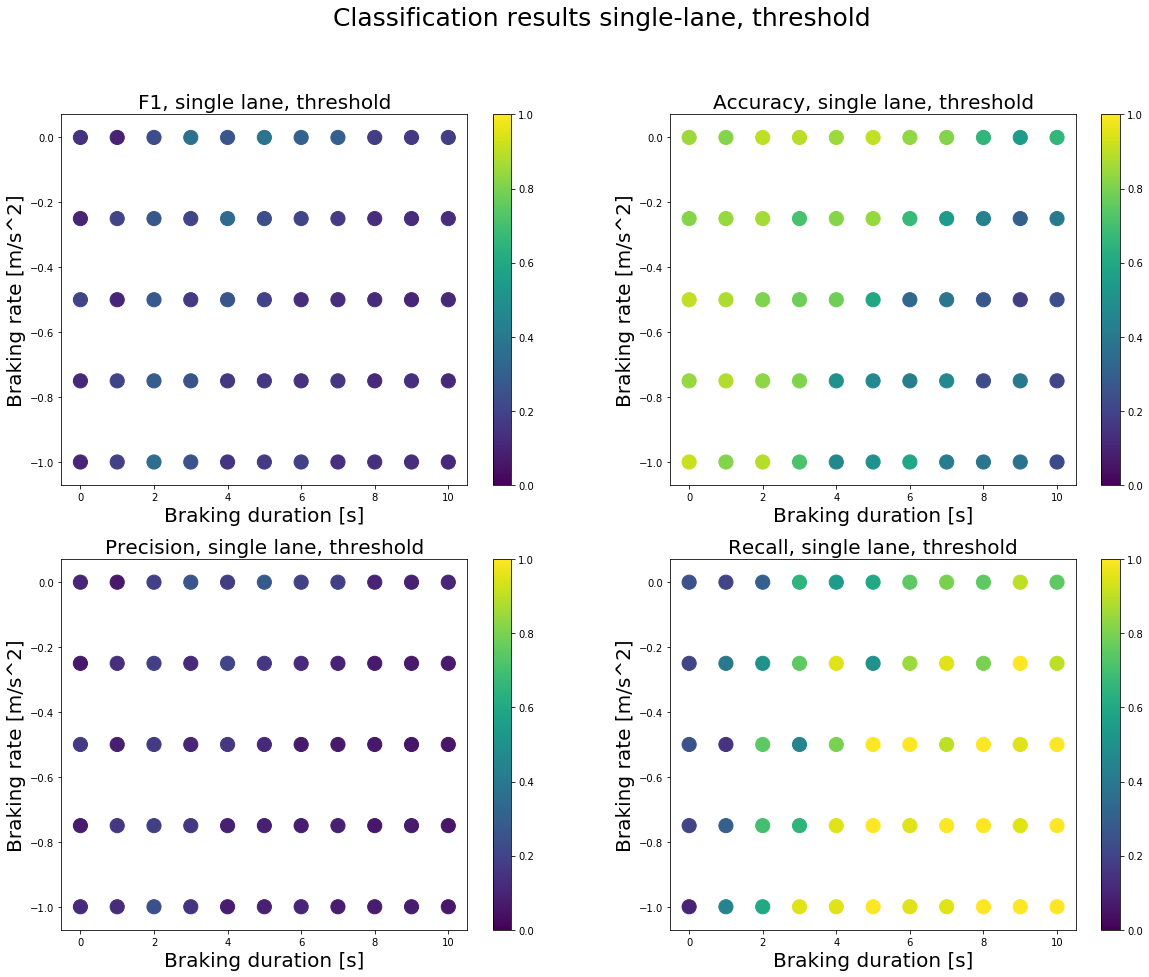

In [110]:
def get_f1(num_FP,num_TP,num_FN,num_TN):
    return num_TP/(num_TP + 0.5*(num_FP + num_FN))

def get_accuracy(FP,TP,FN,TN):
    return (TP + TN)/(FP + FN + TN + TP)

def get_precision(FP,TP,FN,TN):
    return TP/(FP + TP)

def get_recall(FP,TP,FN,TN):
    return TP/(TP + FN)


f1_vals_threshold = []
accuracy_vals_threshold = []
precision_vals_threshold = []
recall_vals_threshold = []

for i in range(len(param_vals)):
    
    FP = FP_vals[i]
    TP = TP_vals[i]
    FN = FN_vals[i]
    TN = TN_vals[i]
    
    f1_vals_threshold.append(get_f1(FP,TP,FN,TN))
    accuracy_vals_threshold.append(get_accuracy(FP,TP,FN,TN))
    precision_vals_threshold.append(get_precision(FP,TP,FN,TN))
    recall_vals_threshold.append(get_recall(FP,TP,FN,TN))
    
fig = plt.figure(figsize=[20,15])
plt.subplot(2,2,1)
plt.scatter(TAD,ADR,c=f1_vals_threshold,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.clim([0,1])
plt.title('F1, single lane, threshold',fontsize=20)

# plt.figure(figsize=[10,7])
plt.subplot(2,2,2)
plt.scatter(TAD,ADR,c=accuracy_vals_threshold,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.clim([0,1])
plt.title('Accuracy, single lane, threshold',fontsize=20)

# plt.figure(figsize=[10,7])
plt.subplot(2,2,3)
plt.scatter(TAD,ADR,c=precision_vals_threshold,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.clim([0,1])
plt.title('Precision, single lane, threshold',fontsize=20)

# plt.figure(figsize=[10,7])
plt.subplot(2,2,4)
plt.scatter(TAD,ADR,c=recall_vals_threshold,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.clim([0,1])
plt.title('Recall, single lane, threshold',fontsize=20)


fig.suptitle('Classification stats single-lane, threshold', fontsize=25)

In [63]:
reload(utils)
from utils import k_means_classify


max_losses_benign = []
for veh_id in losses_dict_benign:
    max_loss = np.max(losses_dict_benign[veh_id][500:])
    max_losses_benign.append(max_loss)

# labels = k_means_classify(max_losses_benign)



cluster_diff_vals = list(np.linspace(0,1,30))

# labels = k_means_classify(max_losses_benign,cluster_diff_vals[3])

# print(np.sum(labels))


# print(cluster_diff_vals)

plt.figure()

FP_vals = []

for cluster_diff in cluster_diff_vals:
    labels,centroids = k_means_classify(max_losses_benign,cluster_diff)
    FP_vals.append(np.sum(labels))

print(np.round(cluster_diff_vals,3))
print(FP_vals)



[0.    0.034 0.069 0.103 0.138 0.172 0.207 0.241 0.276 0.31  0.345 0.379
 0.414 0.448 0.483 0.517 0.552 0.586 0.621 0.655 0.69  0.724 0.759 0.793
 0.828 0.862 0.897 0.931 0.966 1.   ]
[15, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<Figure size 432x288 with 0 Axes>

In [65]:
reload(process_losses_ring_attack)

from process_losses_ring_attack import get_all_loss_results_by_sim

all_max_losses_dict_by_sim = get_all_loss_results_by_sim(loss_results_repo)

print('Finished.')



Finished.


In [89]:
key = attack_keys[40]
params = get_attack_params(key)
print(params)

max_losses_temp_benign = all_max_losses_dict_by_sim[key]['ben']
max_losses_temp_mal = all_max_losses_dict_by_sim[key]['mal']

print(len(max_losses_temp_benign))

num_sims = len(max_losses_temp_benign)
labels_ben = []
labels_mal = []

# plt.figure()
# plt.subplot(2,1,1)
for i in range(num_sims):
    benign_max_losses_individual_sim = max_losses_temp_benign[i]
    num_benign_samples = len(benign_max_losses_individual_sim)
    mal_max_losses_individual_sim = max_losses_temp_mal[i]
    num_mal_samples = len(mal_max_losses_individual_sim)

    all_losses_individual_sim = benign_max_losses_individual_sim + mal_max_losses_individual_sim
    
#     plt.subplot(2,1,1)
#     plt.plot(all_losses_individual_sim,'.')
    
#     plt.subplot(2,1,2)
#     plt.plot(benign_max_losses_individual_sim,'g.')
#     plt.plot(mal_max_losses_individual_sim,'r.')
    
    
    labels_relative,clusters = k_means_classify(all_losses_individual_sim,cluster_diff)

    labels_ben_individual_sim = labels[:num_benign_samples]
    labels_mal_individual_sim = labels[num_benign_samples:]

    for label in labels_ben_individual_sim:
        labels_ben.append(label)
    for label in labels_mal_individual_sim:
        labels_mal.append(label)
        
number_false_positives = np.sum(np.array(labels_ben) == 1)
number_true_positives = np.sum(labels_mal == 1)

number_false_negatives = np.sum(labels_mal == 0)
number_true_negatives = np.sum(labels_ben == 0)


# print(np.array(labels_ben) == 1)
print(np.sum(np.array(labels_ben) == 1))

print(labels_mal)
print(labels_ben)
print(number_false_positives)
print(number_true_positives)
print(number_false_negatives)
print(number_true_negatives)



[7.0, -0.25]
10
0
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [93]:
FP_vals_relative = []
TP_vals_relative = []
TN_vals_relative = []
FN_vals_relative = []


cluster_diff = 0.1

param_vals = []

for key in attack_keys:
    
    params = get_attack_params(key)
    param_vals.append(params)
    
    max_losses_temp_benign = all_max_losses_dict_by_sim[key]['ben']
    max_losses_temp_mal = all_max_losses_dict_by_sim[key]['mal']
    
    #list of lists of max losses per sim:
    num_sims = len(max_losses_temp_benign)
    labels_ben = []
    labels_mal = []

    for i in range(num_sims):
        benign_max_losses_individual_sim = max_losses_temp_benign[i]
        num_benign_samples = len(benign_max_losses_individual_sim)
        mal_max_losses_individual_sim = max_losses_temp_mal[i]
        num_mal_samples = len(mal_max_losses_individual_sim)
        
        all_losses_individual_sim = benign_max_losses_individual_sim + mal_max_losses_individual_sim
        
        labels,clusters = k_means_classify(all_losses_individual_sim,cluster_diff)
        
        labels_ben_individual_sim = labels[:num_benign_samples]
        labels_mal_individual_sim = labels[num_benign_samples:]
        
        for label in labels_ben_individual_sim:
            labels_ben.append(label)
        for label in labels_mal_individual_sim:
            labels_mal.append(label)
    

    
    number_false_positives = np.sum(np.array(labels_ben) == 1)
    number_true_positives = np.sum(np.array(labels_mal) == 1)

    number_false_negatives = np.sum(np.array(labels_mal) == 0)
    number_true_negatives = np.sum(np.array(labels_ben) == 0)
    
    FP_vals_relative.append(number_false_positives)
    TP_vals_relative.append(number_true_positives)
    FN_vals_relative.append(number_false_negatives)
    TN_vals_relative.append(number_true_negatives)
    
print('Found classification statistics.')

Found classification statistics.


In [94]:
print(FP_vals_relative)

[12, 21, 56, 37, 17, 13, 24, 31, 18, 36, 1, 1, 0, 1, 17, 28, 22, 8, 13, 12, 25, 15, 22, 14, 24, 5, 14, 20, 4, 18, 19, 2, 1, 6, 18, 11, 1, 2, 1, 9, 1, 1, 3, 1, 6, 0, 1, 3, 0, 11, 4, 0, 0, 8, 6]


Text(0.5, 0.98, 'Classification results single-lane, k-means relative')

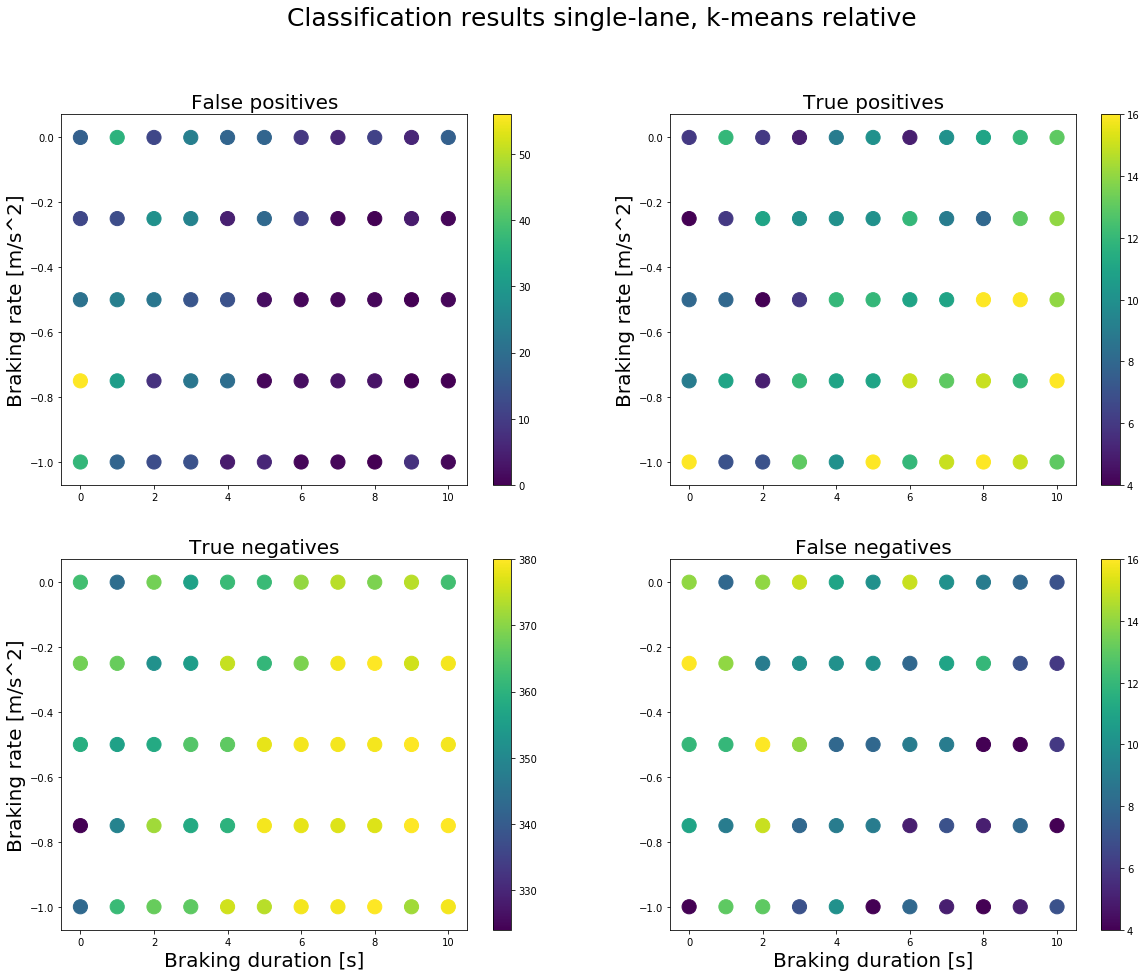

In [95]:
fig = plt.figure(figsize=[20,15])


dot_size = 200


param_vals_np_arr = np.array(param_vals)

TAD = param_vals_np_arr[:,0]
ADR = param_vals_np_arr[:,1]

plt.subplot(2,2,1)
plt.scatter(TAD,ADR,c=FP_vals_relative,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
# plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.title('False positives',fontsize=20)


plt.subplot(2,2,2)
plt.scatter(TAD,ADR,c=TP_vals_relative,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
# plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.title('True positives',fontsize=20)

plt.subplot(2,2,3)
plt.scatter(TAD,ADR,c=TN_vals_relative,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.title('True negatives',fontsize=20)

plt.subplot(2,2,4)
plt.scatter(TAD,ADR,c=FN_vals_relative,s=dot_size)
# plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.title('False negatives',fontsize=20)

fig.suptitle('Classification results single-lane, k-means relative', fontsize=25)
    
# fig.title('Classification results')

Text(0.5, 0.98, 'Classification stats single-lane, k-means relative')

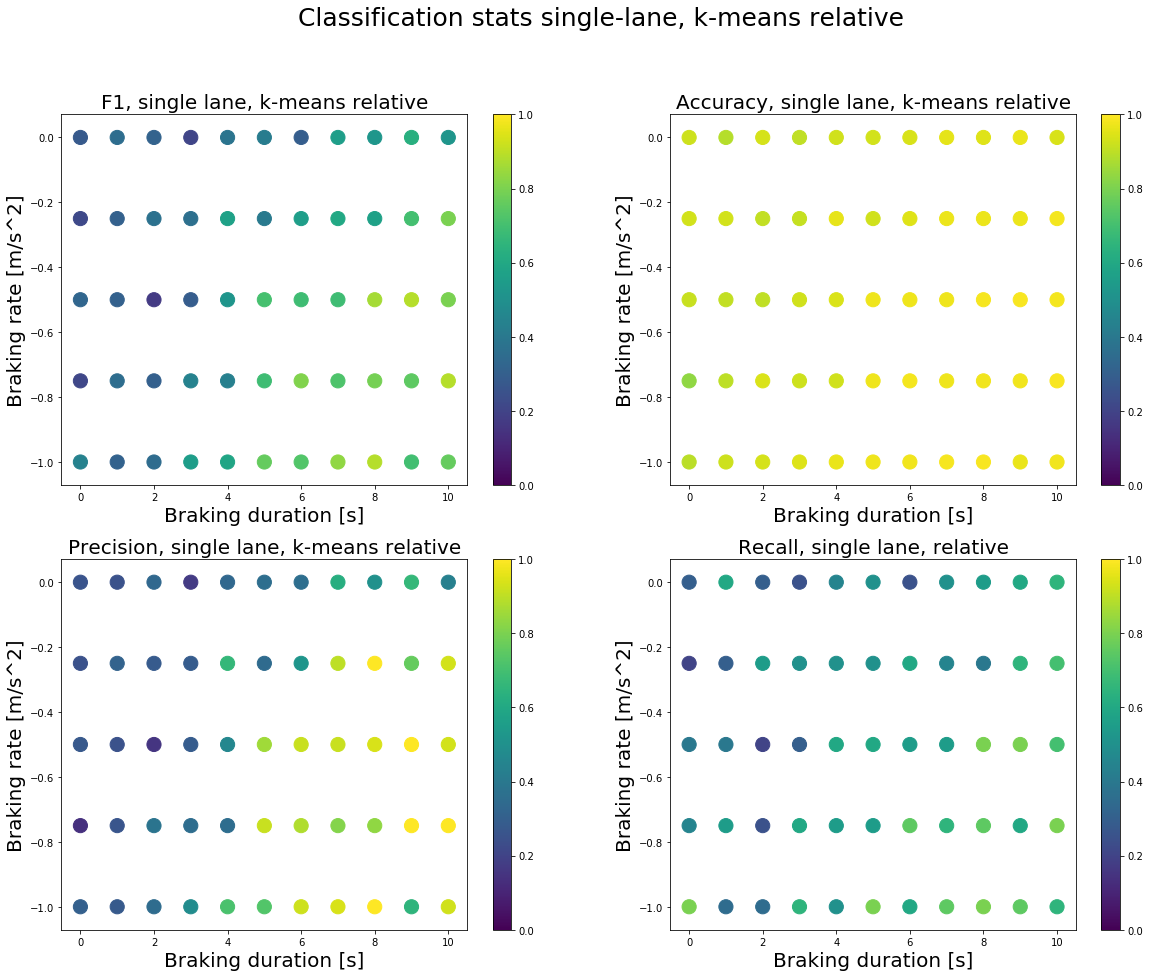

In [111]:
def get_f1(num_FP,num_TP,num_FN,num_TN):
    return num_TP/(num_TP + 0.5*(num_FP + num_FN))

def get_accuracy(FP,TP,FN,TN):
    return (TP + TN)/(FP + FN + TN + TP)

def get_precision(FP,TP,FN,TN):
    return TP/(FP + TP)

def get_recall(FP,TP,FN,TN):
    return TP/(TP + FN)


f1_vals_relative = []
accuracy_vals_relative = []
precision_vals_relative = []
recall_vals_relative = []

for i in range(len(param_vals)):
    
    FP = FP_vals_relative[i]
    TP = TP_vals_relative[i]
    FN = FN_vals_relative[i]
    TN = TN_vals_relative[i]
    
    f1_vals_relative.append(get_f1(FP,TP,FN,TN))
    accuracy_vals_relative.append(get_accuracy(FP,TP,FN,TN))
    precision_vals_relative.append(get_precision(FP,TP,FN,TN))
    recall_vals_relative.append(get_recall(FP,TP,FN,TN))
    
fig = plt.figure(figsize=[20,15])
plt.subplot(2,2,1)
plt.scatter(TAD,ADR,c=f1_vals_relative,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.clim([0,1])
plt.title('F1, single lane, k-means relative',fontsize=20)

# plt.figure(figsize=[10,7])
plt.subplot(2,2,2)
plt.scatter(TAD,ADR,c=accuracy_vals_relative,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.clim([0,1])
plt.title('Accuracy, single lane, k-means relative',fontsize=20)

# plt.figure(figsize=[10,7])
plt.subplot(2,2,3)
plt.scatter(TAD,ADR,c=precision_vals_relative,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.clim([0,1])
plt.title('Precision, single lane, k-means relative',fontsize=20)

# plt.figure(figsize=[10,7])
plt.subplot(2,2,4)
plt.scatter(TAD,ADR,c=recall_vals_relative,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.clim([0,1])
plt.title('Recall, single lane, relative',fontsize=20)


fig.suptitle('Classification stats single-lane, k-means relative', fontsize=25)

In [114]:
import attack_param_sweep_double_lane
reload(attack_param_sweep_double_lane)

from attack_param_sweep_double_lane import make_benign_driver_list as make_benign_driver_list_double_lane

from attack_param_sweep_double_lane import make_mal_driver_list as make_mal_driver_list_double_lane


driver_controller_list_no_attack_double_lane = make_benign_driver_list_double_lane()

emission_path = 'data'

benign_sim_emission_path_double_lane = run_ring_sim_variable_cfm(driver_controller_list = driver_controller_list_no_attack_double_lane,
                                                     num_lanes=2,
                                                     ring_length=600,
                                                     sim_time=300,
                                                     emission_path=emission_path)

benign_sim_emission_path_double_lane = benign_sim_emission_path_double_lane[1]

Number of classes of driver: 80
Running ring simulation, ring length: 600


/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 1508.5156097540803
data/ring_variable_cfm_20220531-1050571654012257.826792-0_emission.csv data
Average, std velocities: 5.73734308015315, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1508.5156097540803, 0.0
Total time: 61.596399784088135
steps/second: 54.38842392002352


In [115]:
model_double_lane = get_cnn_lstm_ae_model(n_features=4)

# Load in a trained model:
MODEL_PATH = '/Users/vanderbilt/Desktop/Research_2022/Anti-Flow/detector_dev/models/cnn_lstm_ae_ringlength600_1.0percentGPS.pt'
model_double_lane.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device('cpu')))

losses_dict_benign_double_lane = get_losses_complete_obs(benign_sim_emission_path_double_lane,model_double_lane)

print('Loaded losses from non attacked 2-lane sim.')

Data loaded.
Vehicles processed: 80

Loaded losses from non attacked 2-lane sim.


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/My Passport for Mac/single_lane_ring_road_attack_parameter_sweep/loss_results_1.0_GPS/loss_results_1.0_GPS'

In [116]:
loss_results_repo_double_lane = '/Volumes/My Passport for Mac/double_lane_ring_road_attack_parameter_sweep'
loss_results_repo_double_lane = os.path.join(loss_results_repo_double_lane,'loss_results_1.0_GPS')

all_max_losses_dict_double_lane = get_all_loss_results(loss_results_repo_double_lane)

print('Loaded max losses from double lane simulations.')

Loaded max losses from double lane simulations.


152.54142402648927


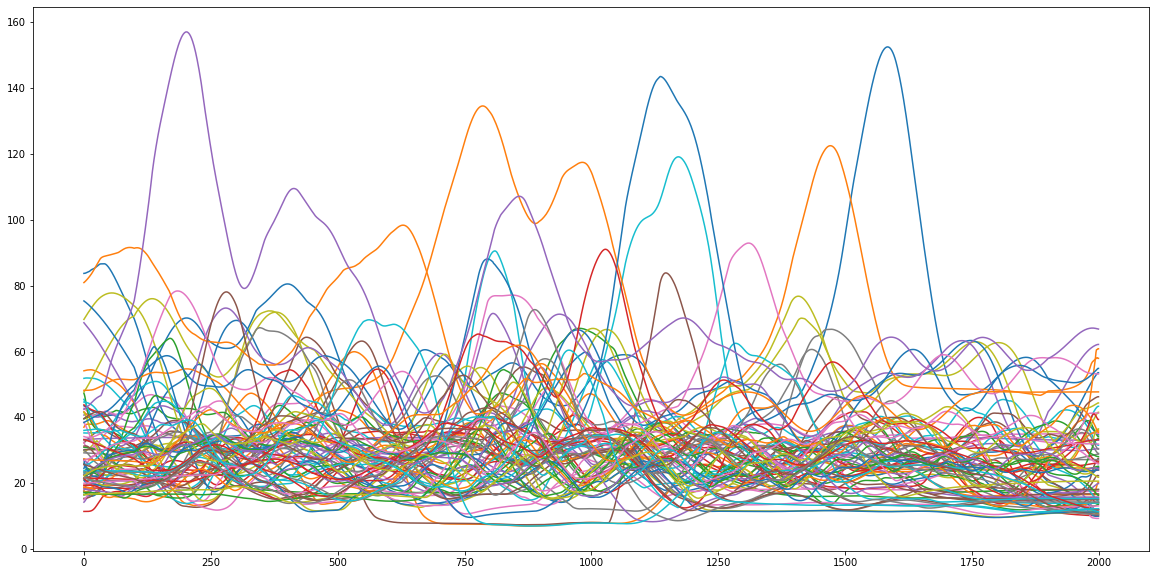

In [130]:
plt.figure(figsize=[20,10])

for veh_id in losses_dict_benign_double_lane:
    plt.plot(losses_dict_benign_double_lane[veh_id])

max_loss_all_double_lane = 0.0

for veh_id in losses_dict_benign_double_lane:
    max_loss = np.max(losses_dict_benign_double_lane[veh_id][500:])
    if(max_loss > max_loss_all_double_lane): max_loss_all_double_lane = max_loss
        
print(max_loss_all_double_lane)

In [131]:
def get_threshold_classification(all_max_losses_dict,max_loss_all):

	attack_keys = list(all_max_losses_dict.keys())

	param_vals = []

	FP_vals = []
	TP_vals = []
	TN_vals = []
	FN_vals = []

	for key in attack_keys:
		
		params = get_attack_params(key)
		param_vals.append(params)
		
		max_losses_temp_benign = all_max_losses_dict[key]['ben']
		max_losses_temp_mal = all_max_losses_dict[key]['mal']
		
		labels_ben = threshold_classification(max_losses=max_losses_temp_benign,threshold=max_loss_all)
		labels_mal = threshold_classification(max_losses=max_losses_temp_mal,threshold=max_loss_all)
		
		number_false_positives = np.sum(np.array(labels_ben) == 1)
		number_true_positives = np.sum(np.array(labels_mal) == 1)

		number_false_negatives = np.sum(np.array(labels_mal) == 0)
		number_true_negatives = np.sum(np.array(labels_ben) == 0)
		
		FP_vals.append(number_false_positives)
		TP_vals.append(number_true_positives)
		FN_vals.append(number_false_negatives)
		TN_vals.append(number_true_negatives)

	return [param_vals,FP_vals,TP_vals,FN_vals,TN_vals]


[param_vals_threshold_double_lane,
 FP_vals_threshold_double_lane,
 TP_vals_threshold_double_lane,
 FN_vals_threshold_double_lane,
 TN_vals_threshold_double_lane] = get_threshold_classification(all_max_losses_dict_double_lane,max_loss_all_double_lane)

print('Finished.')

Finished.


In [125]:
def get_kmeans_classification(all_max_losses_dict_by_sim,cluster_diff=0.1):
    FP_vals = []
    TP_vals = []
    TN_vals = []
    FN_vals = []

    param_vals = []

    for key in attack_keys:
        
        params = get_attack_params(key)
        param_vals.append(params)
        
        max_losses_temp_benign = all_max_losses_dict_by_sim[key]['ben']
        max_losses_temp_mal = all_max_losses_dict_by_sim[key]['mal']
        
        #list of lists of max losses per sim:
        num_sims = len(max_losses_temp_benign)
        labels_ben = []
        labels_mal = []

        for i in range(num_sims):
            benign_max_losses_individual_sim = max_losses_temp_benign[i]
            num_benign_samples = len(benign_max_losses_individual_sim)
            mal_max_losses_individual_sim = max_losses_temp_mal[i]
            num_mal_samples = len(mal_max_losses_individual_sim)
            
            all_losses_individual_sim = benign_max_losses_individual_sim + mal_max_losses_individual_sim
            
            labels,clusters = k_means_classify(all_losses_individual_sim,cluster_diff)
            
            labels_ben_individual_sim = labels[:num_benign_samples]
            labels_mal_individual_sim = labels[num_benign_samples:]
            
            for label in labels_ben_individual_sim:
                labels_ben.append(label)
            for label in labels_mal_individual_sim:
                labels_mal.append(label)
        

        
        number_false_positives = np.sum(np.array(labels_ben) == 1)
        number_true_positives = np.sum(np.array(labels_mal) == 1)

        number_false_negatives = np.sum(np.array(labels_mal) == 0)
        number_true_negatives = np.sum(np.array(labels_ben) == 0)
        
        FP_vals.append(number_false_positives)
        TP_vals.append(number_true_positives)
        FN_vals.append(number_false_negatives)
        TN_vals.append(number_true_negatives)


    return [param_vals,FP_vals,TP_vals,FN_vals,TN_vals]

all_max_losses_by_sim_dict_double_lane = get_all_loss_results_by_sim(loss_results_repo_double_lane)


[param_vals_kmeans_double_lane,
 FP_vals_kmeans_double_lane,
 TP_vals_kmeans_double_lane,
 FN_vals_kmeans_double_lane,
 TN_vals_kmeans_double_lane] = get_kmeans_classification(all_max_losses_by_sim_dict_double_lane)

print('Finished.')

Finished.


/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


Text(0.5, 0.98, 'Classification stats double-lane, k-means relative')

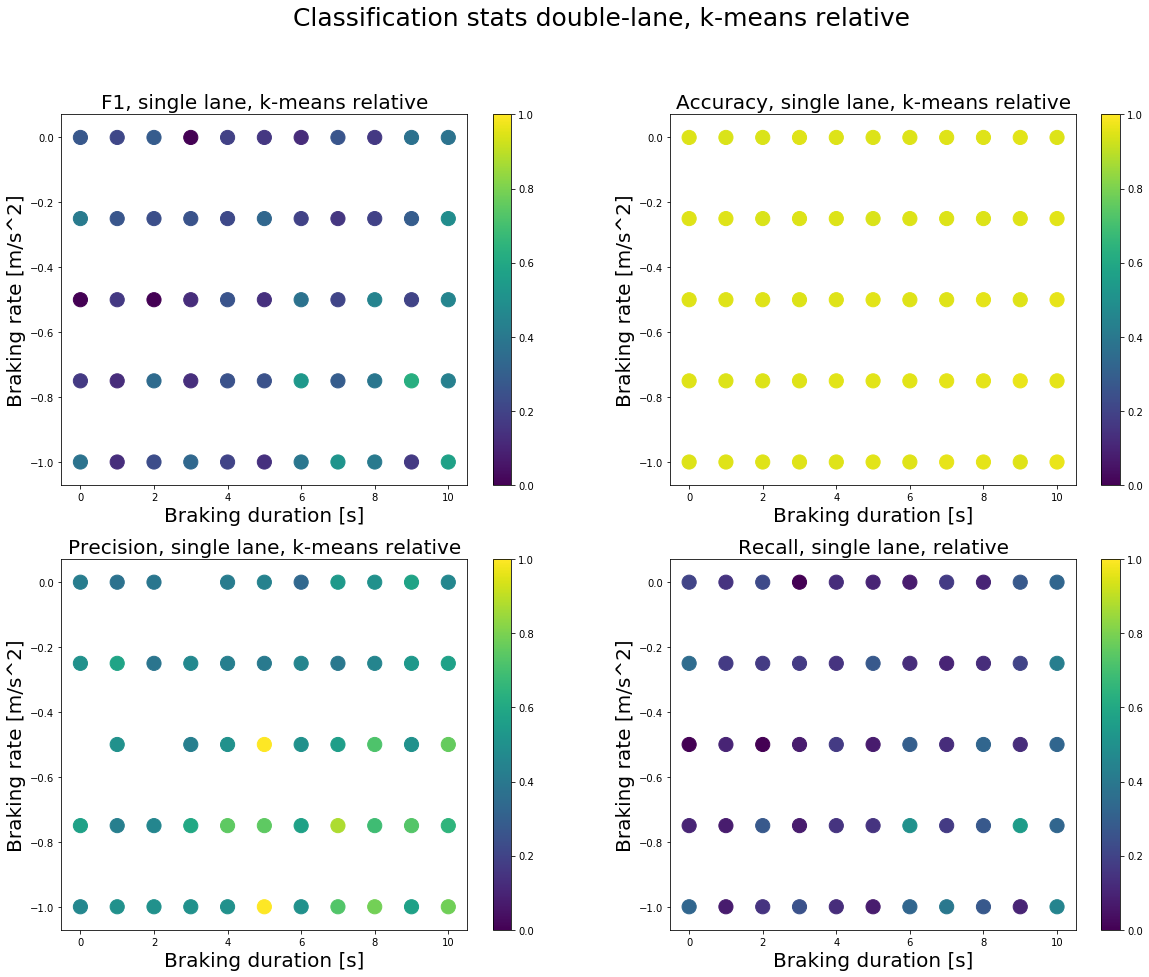

In [128]:
f1_vals_kmeans_double_lane = []
accuracy_vals_kmeans_double_lane = []
precision_vals_kmeans_double_lane = []
recall_vals_kmeans_double_lane = []

for i in range(len(param_vals)):
    
    FP = FP_vals_kmeans_double_lane[i]
    TP = TP_vals_kmeans_double_lane[i]
    FN = FN_vals_kmeans_double_lane[i]
    TN = TN_vals_kmeans_double_lane[i]
    
    f1_vals_kmeans_double_lane.append(get_f1(FP,TP,FN,TN))
    accuracy_vals_kmeans_double_lane.append(get_accuracy(FP,TP,FN,TN))
    precision_vals_kmeans_double_lane.append(get_precision(FP,TP,FN,TN))
    recall_vals_kmeans_double_lane.append(get_recall(FP,TP,FN,TN))
    
fig = plt.figure(figsize=[20,15])
plt.subplot(2,2,1)
plt.scatter(TAD,ADR,c=f1_vals_kmeans_double_lane,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.clim([0,1])
plt.title('F1, single lane, k-means relative',fontsize=20)

# plt.figure(figsize=[10,7])
plt.subplot(2,2,2)
plt.scatter(TAD,ADR,c=accuracy_vals_kmeans_double_lane,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.clim([0,1])
plt.title('Accuracy, single lane, k-means relative',fontsize=20)

# plt.figure(figsize=[10,7])
plt.subplot(2,2,3)
plt.scatter(TAD,ADR,c=precision_vals_kmeans_double_lane,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.clim([0,1])
plt.title('Precision, single lane, k-means relative',fontsize=20)

# plt.figure(figsize=[10,7])
plt.subplot(2,2,4)
plt.scatter(TAD,ADR,c=recall_vals_kmeans_double_lane,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.clim([0,1])
plt.title('Recall, single lane, relative',fontsize=20)


fig.suptitle('Classification stats double-lane, k-means relative', fontsize=25)

Text(0.5, 0.98, 'Classification stats double-lane, threshold')

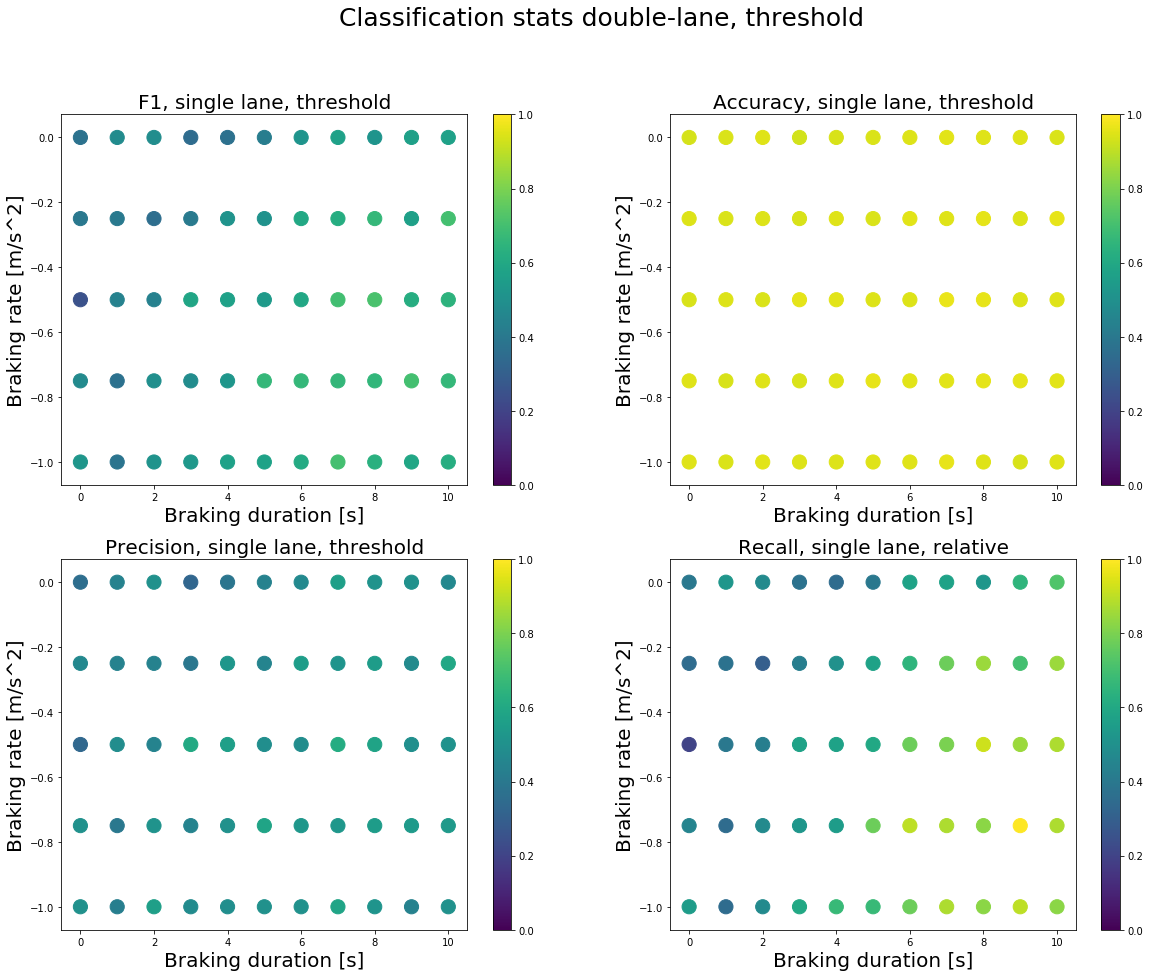

In [132]:
f1_vals_threshold_double_lane = []
accuracy_vals_threshold_double_lane = []
precision_vals_threshold_double_lane = []
recall_vals_threshold_double_lane = []

for i in range(len(param_vals)):
    
    FP = FP_vals_threshold_double_lane[i]
    TP = TP_vals_threshold_double_lane[i]
    FN = FN_vals_threshold_double_lane[i]
    TN = TN_vals_threshold_double_lane[i]
    
    f1_vals_threshold_double_lane.append(get_f1(FP,TP,FN,TN))
    accuracy_vals_threshold_double_lane.append(get_accuracy(FP,TP,FN,TN))
    precision_vals_threshold_double_lane.append(get_precision(FP,TP,FN,TN))
    recall_vals_threshold_double_lane.append(get_recall(FP,TP,FN,TN))
    
fig = plt.figure(figsize=[20,15])
plt.subplot(2,2,1)
plt.scatter(TAD,ADR,c=f1_vals_threshold_double_lane,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.clim([0,1])
plt.title('F1, single lane, threshold',fontsize=20)

# plt.figure(figsize=[10,7])
plt.subplot(2,2,2)
plt.scatter(TAD,ADR,c=accuracy_vals_threshold_double_lane,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.clim([0,1])
plt.title('Accuracy, single lane, threshold',fontsize=20)

# plt.figure(figsize=[10,7])
plt.subplot(2,2,3)
plt.scatter(TAD,ADR,c=precision_vals_threshold_double_lane,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.clim([0,1])
plt.title('Precision, single lane, threshold',fontsize=20)

# plt.figure(figsize=[10,7])
plt.subplot(2,2,4)
plt.scatter(TAD,ADR,c=recall_vals_threshold_double_lane,s=dot_size)
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.colorbar()
plt.clim([0,1])
plt.title('Recall, single lane, relative',fontsize=20)


fig.suptitle('Classification stats double-lane, threshold', fontsize=25)

In [136]:
import csv

def load_csv_as_list(file_path):
    data = []
    
    with open(file_path, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            data.append(row)
            
    return data


file_path = '/Volumes/My Passport for Mac/single_lane_ring_road_attack_parameter_sweep/all_impact_metrics_single_lane.csv'

single_lane_attack_impact_metrics_list = load_csv_as_list(file_path)

print('Loaded single lane attack impacts.')


Loaded single lane attack impacts.


In [141]:
# print(single_lane_attack_impact_metrics_list[0][0])
# [TAD,ADR] = process_losses_ring_attack.get_attack_params(single_lane_attack_impact_metrics_list[0][0])
# process_losses_ring_attack.get_attack_identifier(single_lane_attack_impact_metrics_list[0][0])


def get_loss_path(file_path,loss_files_repo):
    num_chars = len(emission_path)

    i = 0
    while(file_path[i:i+3] != 'TAD' and i < num_chars):i += 1
    
    loss_file_name = file_path[i:]
    
    return os.path.join(loss_files_repo,loss_file_name)

loss_files_repo = '/Volumes/My Passport for Mac/single_lane_ring_road_attack_parameter_sweep/loss_results_1.0_GPS'

file_path = single_lane_attack_impact_metrics_list[0][0]

print(get_loss_path(file_path,loss_files_repo))


/Volumes/My Passport for Mac/single_lane_ring_road_attack_parameter_sweep/loss_results_1.0_GPS/umes/My Passport for Mac/single_lane_ring_road_attack_parameter_sweep/ring_600m_single_lane_TAD_0.0_ADR_-0.25_ver_1.csv


In [148]:
attack_impacts = {}

for row in single_lane_attack_impact_metrics_list:
    file_path = row[0]
    impacts = row[1:]
    [TAD,ADR] = process_losses_ring_attack.get_attack_params(file_path)
    key = process_losses_ring_attack.get_attack_identifier(TAD,ADR)
    
    if(key in attack_impacts.keys()):
        attack_impacts[key].append(np.array(impacts).astype(float))
    else:
        attack_impacts[key]=[]
        attack_impacts[key].append(np.array(impacts).astype(float))

print('Finished.')


Finished.


In [150]:
param_val_ids = list(attack_impacts.keys())
print(param_val_ids[0])
temp = np.array(attack_impacts[param_val_ids[0]])
print(temp.shape)
temp_ave = np.mean(temp,axis=0)
print(temp_ave)

TAD_0.0_ADR_-0.25_
(10, 4)
[   6.09773383    6.36803754 1035.89          0.        ]


Text(0.5, 1.0, 'Traffic speed, single lane')

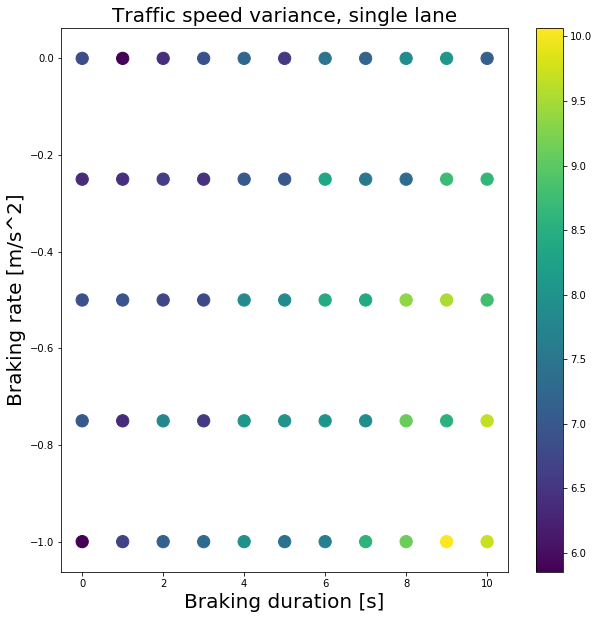

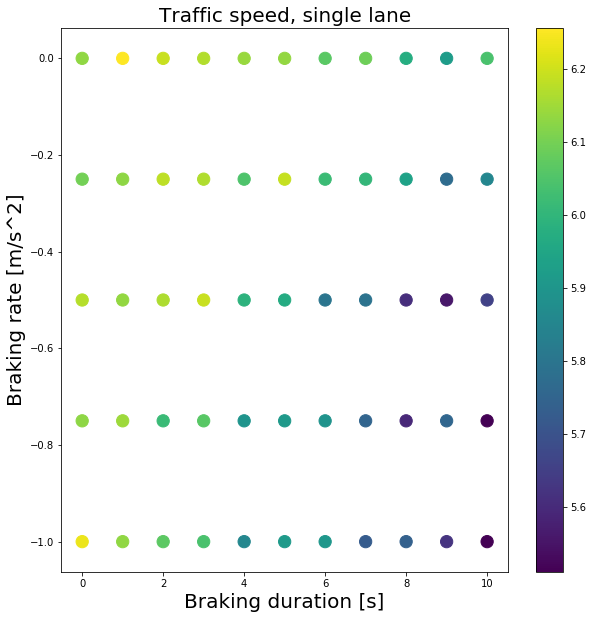

In [165]:
ave_impacts = []
param_vals = []

for param_val_id in attack_impacts:
    impacts = attack_impacts[param_val_id]
    impact_averages = np.mean(impacts,axis=0)
    [TAD,ADR]= process_losses_ring_attack.get_attack_params(param_val_id)
    
    ave_impacts.append(impact_averages)
    param_vals.append([TAD,ADR])
    
    
ave_impacts = np.array(ave_impacts)
param_vals = np.array(param_vals)

plt.figure(figsize=[10,10])
plt.scatter(param_vals[:,0],param_vals[:,1],c=ave_impacts[:,1],s=150)
plt.colorbar()
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.title('Traffic speed variance, single lane',fontsize=20)


plt.figure(figsize=[10,10])
plt.scatter(param_vals[:,0],param_vals[:,1],c=ave_impacts[:,0],s=150)
plt.colorbar()
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.title('Traffic speed, single lane',fontsize=20)


Text(0.5, 0.98, 'Single lane detection vs. impact')

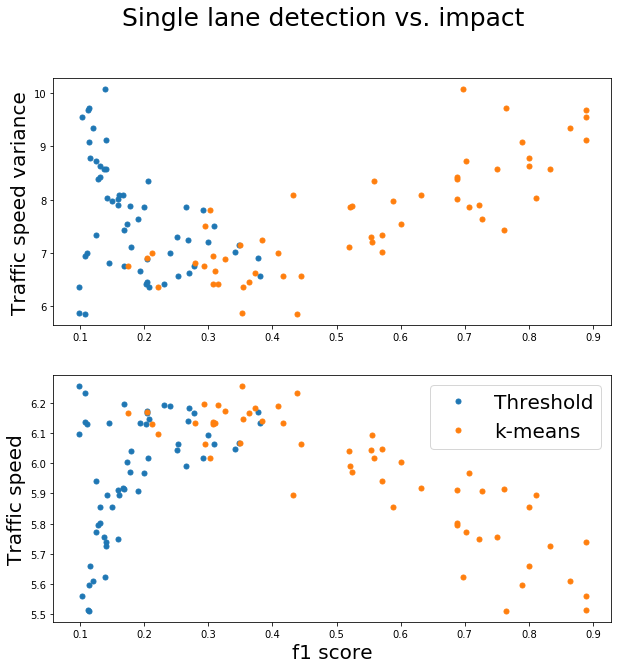

In [168]:

fig = plt.figure(figsize=[10,10])
plt.subplot(2,1,1)
plt.plot(f1_vals_threshold,ave_impacts[:,1],'.',markersize=10,label='Threshold')
plt.plot(f1_vals_relative,ave_impacts[:,1],'.',markersize=10,label='k-means')
plt.ylabel('Traffic speed variance',fontsize=20)

plt.subplot(2,1,2)
plt.plot(f1_vals_threshold,ave_impacts[:,0],'.',markersize=10,label='Threshold')
plt.plot(f1_vals_relative,ave_impacts[:,0],'.',markersize=10,label='k-means')
plt.ylabel('Traffic speed',fontsize=20)

plt.xlabel('f1 score',fontsize=20)
plt.legend(fontsize=20)


fig.suptitle('Single lane, detection vs. impact',fontsize=25)

In [176]:
file_path = '/Volumes/My Passport for Mac/double_lane_ring_road_attack_parameter_sweep/all_impact_metrics_double_lane.csv'

double_lane_attack_impact_metrics_list = load_csv_as_list(file_path)

# print(double_lane_attack_impact_metrics_list[0])

attack_impacts_double_lane = {}

for row in double_lane_attack_impact_metrics_list:
    file_path = row[0]
    impacts = row[1:]
    [TAD,ADR] = process_losses_ring_attack.get_attack_params(file_path)
    key = process_losses_ring_attack.get_attack_identifier(TAD,ADR)
    
    if(key in attack_impacts_double_lane.keys()):
        attack_impacts_double_lane[key].append(np.array(impacts).astype(float))
    else:
        attack_impacts_double_lane[key]=[]
        attack_impacts_double_lane[key].append(np.array(impacts).astype(float))

impact_ids_double_lane = list(attack_impacts_double_lane.keys())
# print(attack_impacts_double_lane[impact_ids_double_lane[0]])

ave_impacts_double_lane = []
param_vals_double_lane = []

for param_val_id in attack_impacts_double_lane:
    impacts = attack_impacts_double_lane[param_val_id]
    impact_averages = np.mean(impacts,axis=0)
    [TAD,ADR]= process_losses_ring_attack.get_attack_params(param_val_id)
    
    ave_impacts_double_lane.append(impact_averages)
    param_vals_double_lane.append([TAD,ADR])
    
    
ave_impacts_double_lane = np.array(ave_impacts_double_lane)
param_vals_double_lane = np.array(param_vals_double_lane)

print('Finished')

[[   5.66345649    5.88130911 1633.43         65.3       ]
 [   5.61401077    6.55555527 1417.64         70.        ]
 [   5.6450671     6.78549158 1641.73         68.        ]
 [   5.66441905    6.25457624 1556.17         58.9       ]
 [   5.58482648    7.31926408 1600.33         66.9       ]
 [   5.6994296     6.12390792 1622.49         61.9       ]
 [   5.62410321    6.4845438  1525.02         65.8       ]
 [   5.76291469    6.11749819 1702.05         57.        ]
 [   5.63000898    6.49652825 1612.39         63.6       ]
 [   5.58781142    6.89858364 1588.14         70.9       ]
 [   5.4312573     7.55468774 1537.53         69.9       ]
 [   5.26634151    7.4468418  1322.6          81.9       ]
 [   5.32622639    7.02016935 1592.79         63.        ]
 [   5.24936791    7.93561912 1406.92         76.6       ]
 [   5.48987732    7.01446152 1582.91         70.        ]
 [   5.58987306    6.0324016  1457.1          57.6       ]
 [   5.66846563    5.97672612 1742.18         65.7      

Text(0.5, 1.0, 'Lane changes')

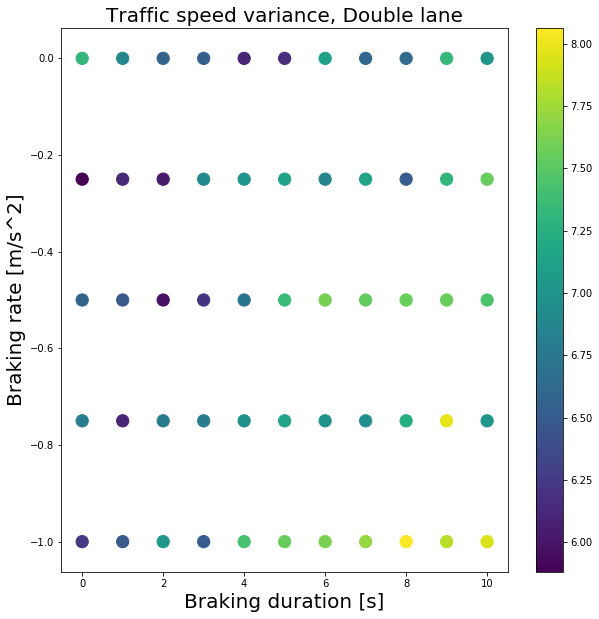

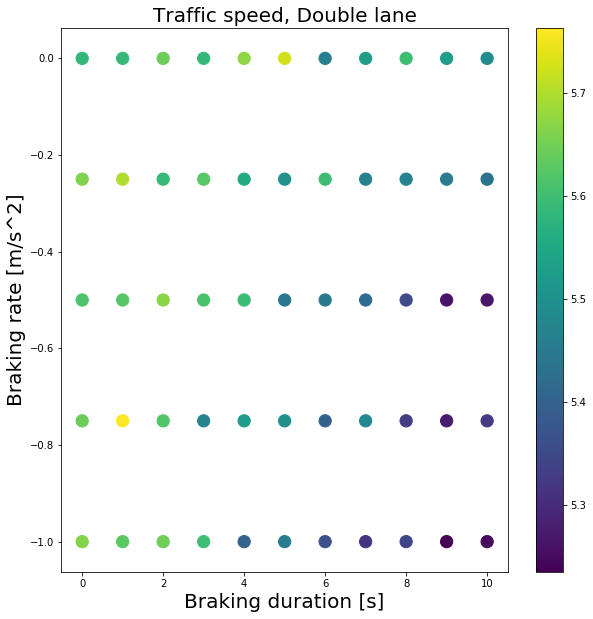

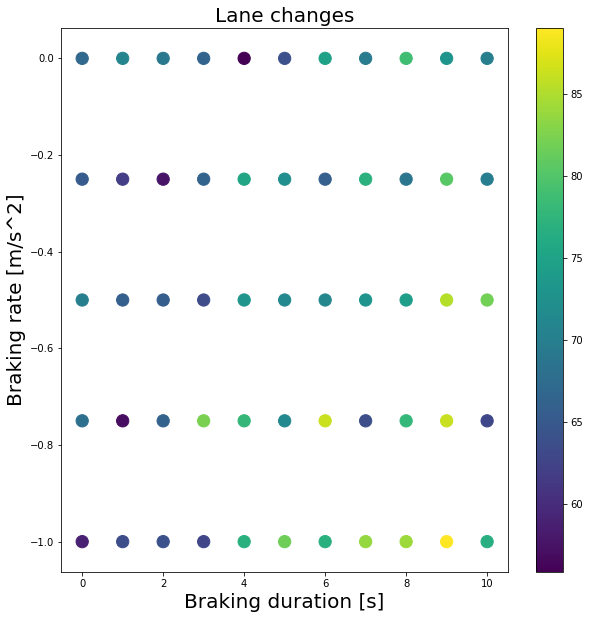

In [177]:
plt.figure(figsize=[10,10])
plt.scatter(param_vals_double_lane[:,0],param_vals_double_lane[:,1],c=ave_impacts_double_lane[:,1],s=150)
plt.colorbar()
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.title('Traffic speed variance, Double lane',fontsize=20)


plt.figure(figsize=[10,10])
plt.scatter(param_vals_double_lane[:,0],param_vals_double_lane[:,1],c=ave_impacts_double_lane[:,0],s=150)
plt.colorbar()
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.title('Traffic speed, Double lane',fontsize=20)


plt.figure(figsize=[10,10])
plt.scatter(param_vals_double_lane[:,0],param_vals_double_lane[:,1],c=ave_impacts_double_lane[:,3],s=150)
plt.colorbar()
plt.ylabel('Braking rate [m/s^2]',fontsize=20)
plt.xlabel('Braking duration [s]',fontsize=20)
plt.title('Lane changes',fontsize=20)


Text(0.5, 0.98, 'Double lane, detection vs. impact')

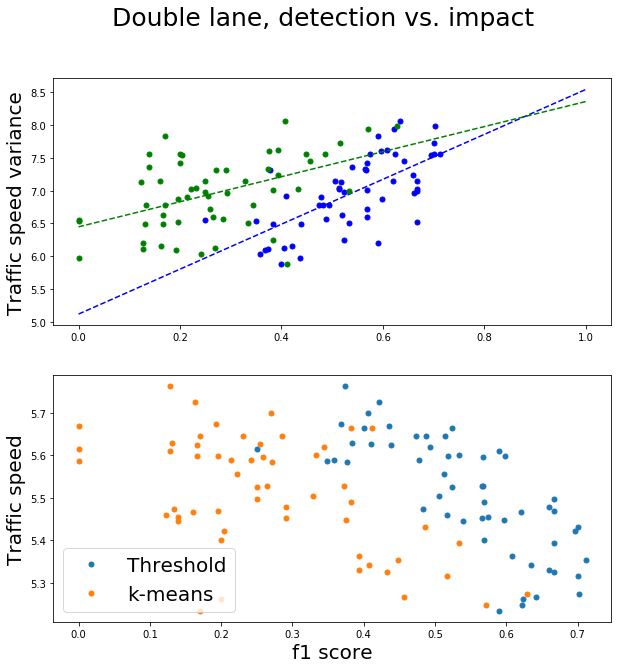

In [252]:
def plot_f1_line(f1,impact,plot_color='b--'):
    x = np.array(f1)
    y = np.array(impact)
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    x_plot = np.array([0,1])
    plt.plot(x_plot, m*x_plot + c,plot_color)

fig = plt.figure(figsize=[10,10])
plt.subplot(2,1,1)
plt.plot(f1_vals_threshold_double_lane,ave_impacts_double_lane[:,1],'b.',markersize=10,label='Threshold')
plot_f1_line(f1_vals_threshold_double_lane,ave_impacts_double_lane[:,1])


plt.plot(f1_vals_kmeans_double_lane,ave_impacts_double_lane[:,1],'g.',markersize=10,label='k-means')
plot_f1_line(f1_vals_kmeans_double_lane,ave_impacts_double_lane[:,1],plot_color='g--')



plt.ylabel('Traffic speed variance',fontsize=20)





plt.subplot(2,1,2)
plt.plot(f1_vals_threshold_double_lane,ave_impacts_double_lane[:,0],'.',markersize=10,label='Threshold')
plt.plot(f1_vals_kmeans_double_lane,ave_impacts_double_lane[:,0],'.',markersize=10,label='k-means')
plt.ylabel('Traffic speed',fontsize=20)

plt.xlabel('f1 score',fontsize=20)
plt.legend(fontsize=20)


fig.suptitle('Double lane, detection vs. impact',fontsize=25)

Text(0.5, 0.98, 'Ring road: detection vs. attack impact')

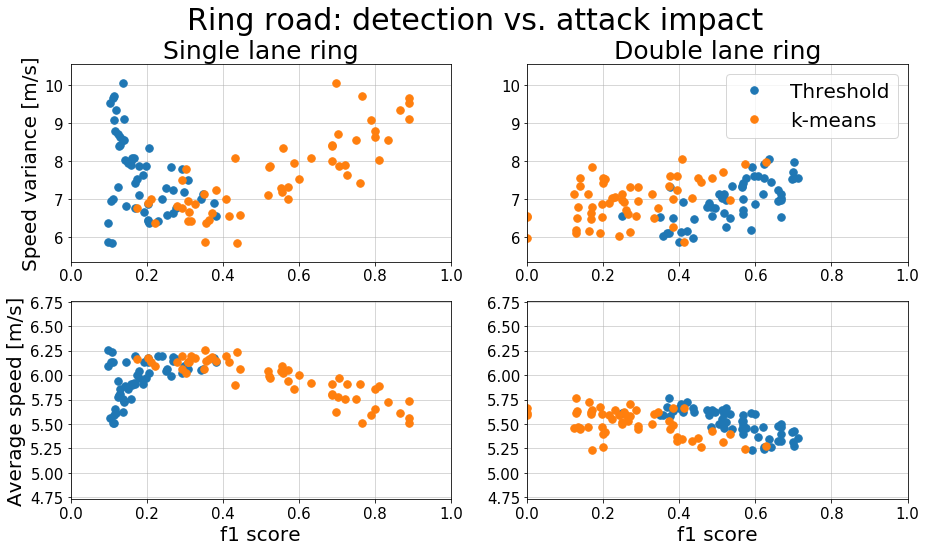

In [242]:
fig = plt.figure(figsize=[15,8])

traffic_speed_lim_upper = np.max([np.max(ave_impacts[:,0]),np.max(ave_impacts_double_lane[:,0])])
traffic_speed_lim_lower = np.min([np.min(ave_impacts[:,0]),np.min(ave_impacts_double_lane[:,0])])
traffic_speed_lims = [traffic_speed_lim_lower-0.5,traffic_speed_lim_upper+0.5]


traffic_variance_lim_upper = np.max([np.max(ave_impacts[:,1]),np.max(ave_impacts_double_lane[:,1])])
traffic_variance_lim_lower = np.min([np.min(ave_impacts[:,1]),np.min(ave_impacts_double_lane[:,1])])
traffic_variance_lims = [traffic_variance_lim_lower-0.5,traffic_variance_lim_upper+0.5]


dot_size = 15
fontsize_defult = 20



plt.subplot(2,2,1)
plt.plot(f1_vals_threshold,ave_impacts[:,1],'.',markersize=dot_size,label='Threshold')
plt.plot(f1_vals_relative,ave_impacts[:,1],'.',markersize=dot_size,label='k-means')
plt.ylabel('Speed variance [m/s]',fontsize=fontsize_defult)
plt.ylim(traffic_variance_lims)
plt.xlim([0,1.0])
plt.title('Single lane ring',fontsize=fontsize_defult+5)
plt.xticks(fontsize=fontsize_defult-5)
plt.yticks(fontsize=fontsize_defult-5)
plt.grid(linewidth=0.5)

plt.subplot(2,2,3)
plt.plot(f1_vals_threshold,ave_impacts[:,0],'.',markersize=dot_size,label='Threshold')
plt.plot(f1_vals_relative,ave_impacts[:,0],'.',markersize=dot_size,label='k-means')
plt.ylabel('Average speed [m/s]',fontsize=fontsize_defult)
plt.xlabel('f1 score',fontsize=fontsize_defult)
plt.xlim([0,1.0])
plt.ylim(traffic_speed_lims)

plt.xticks(fontsize=fontsize_defult-5)
plt.yticks(fontsize=fontsize_defult-5)
plt.grid(linewidth=0.5)
# fig.suptitle('Single lane, detection vs. impact',fontsize=25)


plt.subplot(2,2,2)
plt.plot(f1_vals_threshold_double_lane,ave_impacts_double_lane[:,1],'.',markersize=dot_size,label='Threshold')
plt.plot(f1_vals_kmeans_double_lane,ave_impacts_double_lane[:,1],'.',markersize=dot_size,label='k-means')
plt.xlim([0,1.0])
plt.ylim(traffic_variance_lims)
# plt.ylabel('Traffic speed variance',fontsize=20)
plt.title('Double lane ring',fontsize=fontsize_defult+5)
plt.xticks(fontsize=fontsize_defult-5)
plt.yticks(fontsize=fontsize_defult-5)
plt.grid(linewidth=0.5)
plt.legend(fontsize=fontsize_defult)

plt.subplot(2,2,4)
plt.plot(f1_vals_threshold_double_lane,ave_impacts_double_lane[:,0],'.',markersize=dot_size,label='Threshold')
plt.plot(f1_vals_kmeans_double_lane,ave_impacts_double_lane[:,0],'.',markersize=dot_size,label='k-means')
plt.xlim([0,1.0])
plt.ylim(traffic_speed_lims)
plt.xticks(fontsize=fontsize_defult-5)
plt.yticks(fontsize=fontsize_defult-5)
# plt.ylabel('Traffic speed',fontsize=20)
plt.grid(linewidth=0.5)
plt.xlabel('f1 score',fontsize=fontsize_defult)
# plt.legend(fontsize=20)

fig.suptitle('Ring road: detection vs. attack impact',fontsize=30)

Text(0.5, 0.98, 'Ring road: detection vs. attack impact')

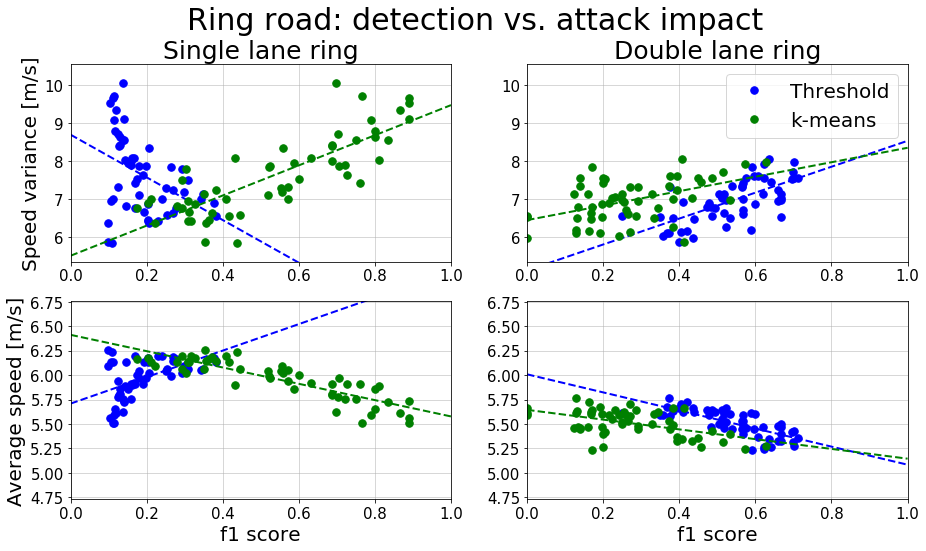

In [258]:
def plot_f1_line(f1,impact,plot_color='b--'):
    x = np.array(f1)
    y = np.array(impact)
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    x_plot = np.array([0,1])
    plt.plot(x_plot, m*x_plot + c,plot_color,linewidth=2)

fig = plt.figure(figsize=[15,8])

traffic_speed_lim_upper = np.max([np.max(ave_impacts[:,0]),np.max(ave_impacts_double_lane[:,0])])
traffic_speed_lim_lower = np.min([np.min(ave_impacts[:,0]),np.min(ave_impacts_double_lane[:,0])])
traffic_speed_lims = [traffic_speed_lim_lower-0.5,traffic_speed_lim_upper+0.5]


traffic_variance_lim_upper = np.max([np.max(ave_impacts[:,1]),np.max(ave_impacts_double_lane[:,1])])
traffic_variance_lim_lower = np.min([np.min(ave_impacts[:,1]),np.min(ave_impacts_double_lane[:,1])])
traffic_variance_lims = [traffic_variance_lim_lower-0.5,traffic_variance_lim_upper+0.5]


dot_size = 15
fontsize_defult = 20



plt.subplot(2,2,1)

plt.plot(f1_vals_threshold,ave_impacts[:,1],'b.',markersize=dot_size,label='Threshold')
plot_f1_line(f1_vals_threshold,ave_impacts[:,1],plot_color='b--')

plt.plot(f1_vals_relative,ave_impacts[:,1],'g.',markersize=dot_size,label='k-means')
plot_f1_line(f1_vals_relative,ave_impacts[:,1],plot_color='g--')


plt.ylabel('Speed variance [m/s]',fontsize=fontsize_defult)
plt.ylim(traffic_variance_lims)
plt.xlim([0,1.0])
plt.title('Single lane ring',fontsize=fontsize_defult+5)
plt.xticks(fontsize=fontsize_defult-5)
plt.yticks(fontsize=fontsize_defult-5)
plt.grid(linewidth=0.5)

plt.subplot(2,2,3)
plt.plot(f1_vals_threshold,ave_impacts[:,0],'b.',markersize=dot_size,label='Threshold')
plot_f1_line(f1_vals_threshold,ave_impacts[:,0],plot_color='b--')

plt.plot(f1_vals_relative,ave_impacts[:,0],'g.',markersize=dot_size,label='k-means')
plot_f1_line(f1_vals_relative,ave_impacts[:,0],plot_color='g--')

plt.ylabel('Average speed [m/s]',fontsize=fontsize_defult)
plt.xlabel('f1 score',fontsize=fontsize_defult)
plt.xlim([0,1.0])
plt.ylim(traffic_speed_lims)

plt.xticks(fontsize=fontsize_defult-5)
plt.yticks(fontsize=fontsize_defult-5)
plt.grid(linewidth=0.5)
# fig.suptitle('Single lane, detection vs. impact',fontsize=25)


plt.subplot(2,2,2)
plt.plot(f1_vals_threshold_double_lane,ave_impacts_double_lane[:,1],'b.',markersize=dot_size,label='Threshold')
plot_f1_line(f1_vals_threshold_double_lane,ave_impacts_double_lane[:,1],plot_color='b--')
plt.plot(f1_vals_kmeans_double_lane,ave_impacts_double_lane[:,1],'g.',markersize=dot_size,label='k-means')
plot_f1_line(f1_vals_kmeans_double_lane,ave_impacts_double_lane[:,1],plot_color='g--')
plt.xlim([0,1.0])
plt.ylim(traffic_variance_lims)
# plt.ylabel('Traffic speed variance',fontsize=20)
plt.title('Double lane ring',fontsize=fontsize_defult+5)
plt.xticks(fontsize=fontsize_defult-5)
plt.yticks(fontsize=fontsize_defult-5)
plt.grid(linewidth=0.5)
plt.legend(fontsize=fontsize_defult)

plt.subplot(2,2,4)
plt.plot(f1_vals_threshold_double_lane,ave_impacts_double_lane[:,0],'b.',markersize=dot_size,label='Threshold')
plot_f1_line(f1_vals_threshold_double_lane,ave_impacts_double_lane[:,0],plot_color='b--')
plt.plot(f1_vals_kmeans_double_lane,ave_impacts_double_lane[:,0],'g.',markersize=dot_size,label='k-means')
plot_f1_line(f1_vals_kmeans_double_lane,ave_impacts_double_lane[:,0],plot_color='g--')
plt.xlim([0,1.0])
plt.ylim(traffic_speed_lims)
plt.xticks(fontsize=fontsize_defult-5)
plt.yticks(fontsize=fontsize_defult-5)
# plt.ylabel('Traffic speed',fontsize=20)
plt.grid(linewidth=0.5)
plt.xlabel('f1 score',fontsize=fontsize_defult)
# plt.legend(fontsize=20)

fig.suptitle('Ring road: detection vs. attack impact',fontsize=30)

Text(0.5, 0.98, 'Ring road: attack impacts')

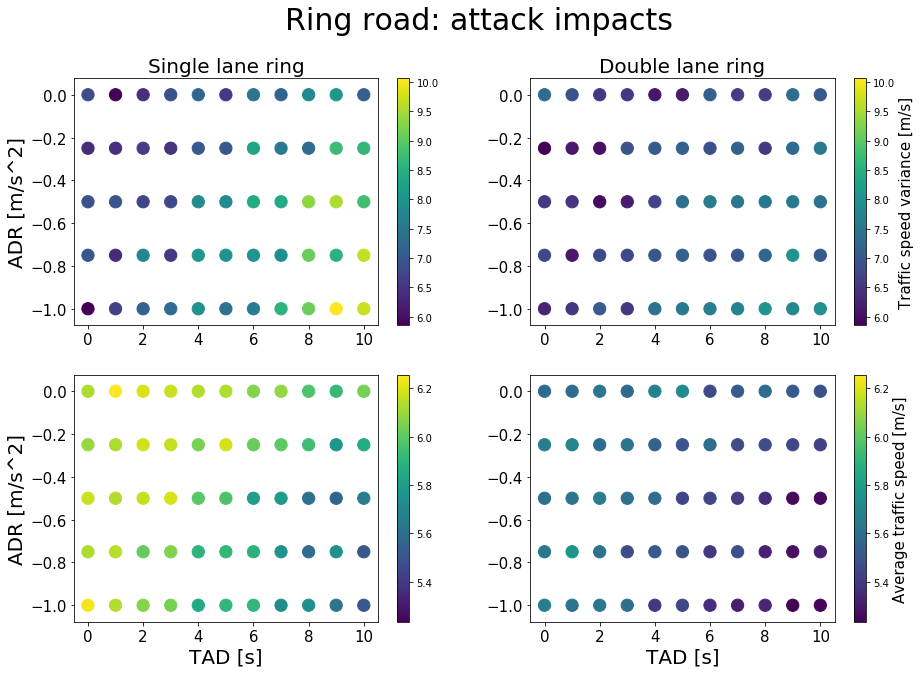

In [230]:
fig = plt.figure(figsize=[15,10])

# traffic_variance_lims = [5.0,10.0]
# traffic_speed_lims = [5.0,7.0]

traffic_speed_lim_upper = np.max([np.max(ave_impacts[:,0]),np.max(ave_impacts_double_lane[:,0])])
traffic_speed_lim_lower = np.min([np.min(ave_impacts[:,0]),np.min(ave_impacts_double_lane[:,0])])
traffic_speed_lims = [traffic_speed_lim_lower,traffic_speed_lim_upper]


traffic_variance_lim_upper = np.max([np.max(ave_impacts[:,1]),np.max(ave_impacts_double_lane[:,1])])
traffic_variance_lim_lower = np.min([np.min(ave_impacts[:,1]),np.min(ave_impacts_double_lane[:,1])])
traffic_variance_lims = [traffic_variance_lim_lower,traffic_variance_lim_upper]



plt.subplot(2,2,1)
plt.scatter(param_vals[:,0],param_vals[:,1],c=ave_impacts[:,1],s=150)
cbar = plt.colorbar()
plt.clim(traffic_variance_lims)
# cbar.set_label('Traffic speed variance [m/s]',fontsize=15)
plt.ylabel('ADR [m/s^2]',fontsize=20)
# plt.xlabel('TAD [s]',fontsize=20)
plt.title('Single lane ring',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(2,2,2)
plt.scatter(param_vals_double_lane[:,0],param_vals_double_lane[:,1],c=ave_impacts_double_lane[:,1],s=150)
cbar = plt.colorbar()
plt.clim(traffic_variance_lims)
cbar.set_label('Traffic speed variance [m/s]',fontsize=15)
# plt.ylabel('ADR [m/s^2]',fontsize=20)
# plt.xlabel('TAD [s]',fontsize=20)
plt.title('Double lane ring',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(2,2,3)
plt.scatter(param_vals[:,0],param_vals_double_lane[:,1],c=ave_impacts[:,0],s=150)
cbar = plt.colorbar()
plt.clim(traffic_speed_lims)
# cbar.set_label('Traffic speed variance [m/s]',fontsize=15)
plt.ylabel('ADR [m/s^2]',fontsize=20)
plt.xlabel('TAD [s]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


plt.subplot(2,2,4)
plt.scatter(param_vals_double_lane[:,0],param_vals_double_lane[:,1],c=ave_impacts_double_lane[:,0],s=150)
cbar = plt.colorbar()
plt.clim(traffic_speed_lims)
cbar.set_label('Average traffic speed [m/s]',fontsize=15)
# plt.ylabel('ADR [m/s^2]',fontsize=20)
plt.xlabel('TAD [s]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.title('Average traffic speed [m/s]',fontsize=20)


fig.suptitle('Ring road: attack impacts',fontsize=30)

In [212]:
from flow.visualize.visualize_ring import get_sim_timeseries_all_data
import numpy as np

def get_attack_impact_metrics(emission_path):
	timeseries_dict = get_sim_timeseries_all_data(emission_path,warmup_period=100)

	average_traffic_speed = 0.0
	traffic_speed_variance = 0.0

	total_time_in_danger = 0.0

	all_speeds = []
	all_spacings = []

	total_lane_changes = 0

	for veh_id in timeseries_dict:
		data = timeseries_dict[veh_id]
		speeds = []
		spacings = []

		dt = float(data[1][0])- float(data[0][0])

		prev_lane = data[0][-3]

		for i in range(len(data)):
			v = float(data[i][4])
			s = float(data[i][5])

			t_g = s/(v + .001) #avoid divide by zero

			if(t_g < 1.0): total_time_in_danger += dt

			speeds.append(v)
			spacings.append(s)

			if(prev_lane != data[i][-3]):
				total_lane_changes += 1

			prev_lane = data[i][-3]

		average_traffic_speed += np.mean(speeds)
		traffic_speed_variance += np.var(speeds)


	average_traffic_speed = average_traffic_speed/len(timeseries_dict)
	traffic_speed_variance = traffic_speed_variance/len(timeseries_dict)

	return [average_traffic_speed,traffic_speed_variance,total_time_in_danger,total_lane_changes]

single_lane_benign_sim_path = benign_sim_emission_path

double_lane_benign_sim_path = benign_sim_emission_path_double_lane

# import process_losses_ring_attack
# reload(process_losses_ring_attack)

# from process_losses_ring_attack import get_attack_impact_metrics

single_lane_benign_impact_metrics = get_attack_impact_metrics(single_lane_benign_sim_path)

double_lane_benign_impact_metrics = get_attack_impact_metrics(double_lane_benign_sim_path)


print('Finished.')

Data loaded.
Data loaded.
Finished.


In [213]:
print(single_lane_benign_impact_metrics)
print(double_lane_benign_impact_metrics)

[6.165231176982433, 4.6811036246508255, 1074.6000000001686, 0]
[5.809651492355498, 4.697012793400775, 1833.6999999994782, 34]


/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


(array([-1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2]),
 <a list of 8 Text yticklabel objects>)

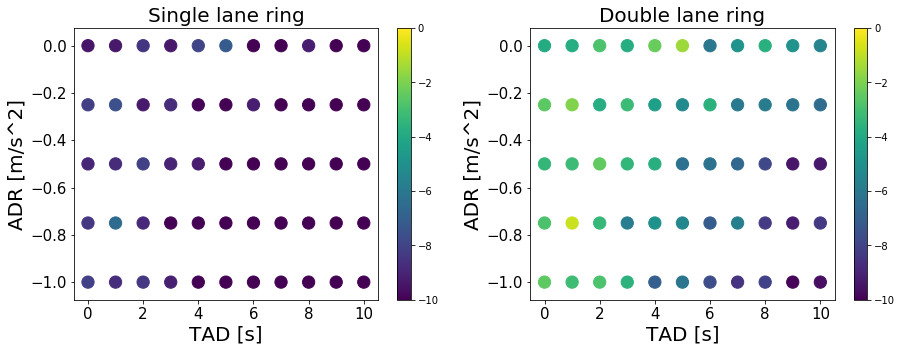

In [225]:
relative_ave_impact_metrics_single_lane = []
benign_impact = single_lane_benign_impact_metrics

for i in range(len(ave_impacts_double_lane)):
    ave_imp = ave_impacts_double_lane[i,:]
  
    change = ave_imp - benign_impact
#     relative_change = change
    relative_change = np.divide(change,benign_impact)*100
                                
    relative_ave_impact_metrics_single_lane.append(relative_change)
    
relative_ave_impact_metrics_single_lane = np.array(relative_ave_impact_metrics_single_lane)



relative_ave_impact_metrics_double_lane = []
benign_impact = double_lane_benign_impact_metrics

for i in range(len(ave_impacts_double_lane)):
    ave_imp = ave_impacts_double_lane[i,:]
  
    change = ave_imp - benign_impact
#     relative_change = change
    relative_change = np.divide(change,benign_impact)*100
                                
    relative_ave_impact_metrics_double_lane.append(relative_change)
    
relative_ave_impact_metrics_double_lane = np.array(relative_ave_impact_metrics_double_lane)


plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.scatter(param_vals[:,0],param_vals[:,1],c=relative_ave_impact_metrics_single_lane[:,0],s=150)
cbar = plt.colorbar()
plt.clim([-10,0])
# cbar.set_label('Relative change in traffic speed variance [m/s]',fontsize=15)
plt.ylabel('ADR [m/s^2]',fontsize=20)
plt.xlabel('TAD [s]',fontsize=20)
plt.title('Single lane ring',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(1,2,2)
plt.scatter(param_vals[:,0],param_vals[:,1],c=relative_ave_impact_metrics_double_lane[:,0],s=150)
cbar = plt.colorbar()
plt.clim([-10,0])
# cbar.set_label('Relative change in traffic speed variance [m/s]',fontsize=15)
plt.ylabel('ADR [m/s^2]',fontsize=20)
plt.xlabel('TAD [s]',fontsize=20)
plt.title('Double lane ring',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

